# ***Prediccion de personalidad Big Five usando MLP (Red Feedforward)***

## Proyecto Final - Introduccion a Deep Learning

Se implementa una Red Neuronal Feedforward (MLP) para modelar rasgos de personalidad del modelo Big Five a partir de las respuestas a un cuestionario psicometrico.

El dataset utilizado es:

- **Big Five Personality Test** (mas de 1 millon de respuestas) disponible en Kaggle en el archivo `data-final.csv`.

Cada persona responde a 50 tipo Likert (preguntas) agrupadas en 5 rasgos:

- **EXT**: Extroversion  
- **EST**: Neuroticismo / Estabilidad Emocional  
- **AGR**: Amabilidad (Agreeableness)  
- **CSN**: Responsabilidad / Escrupulosidad (Conscientiousness)  
- **OPN**: Apertura a la experiencia

A partir de las respuestas:

1. Calculamos una puntuacion agregada para cada rasgo (promedio de los items correspondientes).
2. Definimos la clase objetivo como el rasgo dominante (el de mayor puntaje).
3. Entrenamos un MLP para predecir el rasgo dominante de la persona.

De esta forma el modelo realiza una clasificación multiclase de 5 clases:   
`EXT`, `EST`, `AGR`, `CSN`, `OPN`.



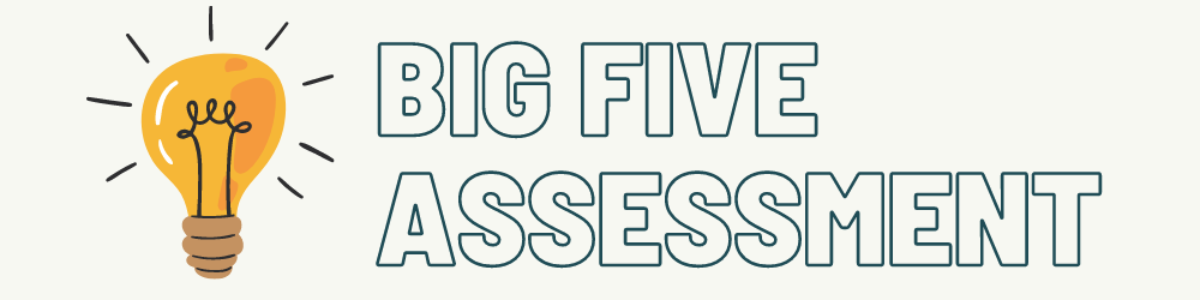

# ***Importacion de librerias y configuracion inicial***

En esta seccion se importan las librerias necesarias para:
- manipular datos (`pandas`, `numpy`)
- visualizar (`matplotlib`, `seaborn`)
- preprocesar y dividir el dataset (`scikit-learn`)
- construir y entrenar el MLP (`PyTorch`)

Tambien se configura una random seed para asegurar que los resultados sean reproducibles entre ejecuciones.


In [12]:
# imports y configuracion general

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# mostrar todas las columnas de pandas
pd.set_option("display.max_columns", None)

#  graficos
sns.set(style="whitegrid", context="notebook")




In [13]:
# seed y GPU (tenia un error que no me dejaba seleccionar, luego se arreglo solo)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    device = torch.device("cuda")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")


# ***carga del dataset de personalidad del Big Five***

En esta seccion se carga el dataset `data-final.csv` que proviene de una prueba de personalidad de tipo Big Five con muchos participantes (pesando aprx 400mb y un millon de filas en csv)

Cada fila corresponde a una persona y cada columna `EXT*, EST*, AGR*, CSN*, OPN*` corresponde a items de los cinco rasgos siendo:
- **EXT**: Extraversion
- **EST**: Inestabilidad emocional / Neuroticismo
- **AGR**: Amabilidad (Agreeableness)
- **CSN**: Responsabilidad (Conscientiousness)
- **OPN**: Apertura a la experiencia (Openness)

hacemos analisis del tamaño del dataset y a las primeras filas.


In [14]:
# carga del dataset Big Five

data_path = Path("data-final.csv")
assert data_path.exists(), "El archivo data-final.csv no se encuentra en el directorio actual."

df_raw = pd.read_csv(data_path, sep="\t")  # viene en tabuladores
print("Shape original:", df_raw.shape)

df_raw.head()


Shape original: (1015341, 110)


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,9419.0,5491.0,3959.0,4821.0,5611.0,2756.0,2388.0,2113.0,5900.0,4110.0,6135.0,4150.0,5739.0,6364.0,3663.0,5070.0,5709.0,4285.0,2587.0,3997.0,4750.0,5475.0,11641.0,3115.0,3207.0,3260.0,10235.0,5897.0,1758.0,3081.0,6602.0,5457.0,1569.0,2129.0,3762.0,4420.0,9382.0,5286.0,4983.0,6339.0,3146.0,4067.0,2959.0,3411.0,2170.0,4920.0,4436.0,3116.0,2992.0,4354.0,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,3.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0,7235.0,3598.0,3315.0,2564.0,2976.0,3050.0,4787.0,3228.0,3465.0,3309.0,9036.0,2406.0,3484.0,3359.0,3061.0,2539.0,4226.0,2962.0,1799.0,1607.0,2158.0,2090.0,2143.0,2807.0,3422.0,5324.0,4494.0,3627.0,1850.0,1747.0,5163.0,5240.0,7208.0,2783.0,4103.0,3431.0,3347.0,2399.0,3360.0,5595.0,2624.0,4985.0,1684.0,3026.0,4742.0,3336.0,2718.0,3374.0,3096.0,3019.0,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,4.0,1.0,4.0,2.0,4.0,1.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,3.0,3.0,4.0,2.0,4.0,2.0,5.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0,4657.0,3549.0,2543.0,3335.0,5847.0,2540.0,4922.0,3142.0,14621.0,2191.0,5128.0,3675.0,3442.0,4546.0,8275.0,2185.0,2164.0,1175.0,3813.0,1593.0,1089.0,2203.0,3386.0,1464.0,2562.0,1493.0,3067.0,13719.0,3892.0,4100.0,4286.0,4775.0,2713.0,2813.0,4237.0,6308.0,2690.0,1516.0,2379.0,2983.0,1930.0,1470.0,1644.0,1683.0,2229.0,8114.0,2043.0,6295.0,1585.0,2529.0,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,4.0,3.0,4.0,2.0,4.0,2.0,4.0,3.0,4.0,2.0,4.0,4.0,4.0,1.0,2.0,2.0,3.0,1.0,4.0,4.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,3996.0,2896.0,5096.0,4240.0,5168.0,5456.0,4360.0,4496.0,5240.0,4000.0,3736.0,4616.0,3015.0,2711.0,3960.0,4064.0,4208.0,2936.0,7336.0,3896.0,6062.0,11952.0,1040.0,2264.0,3664.0,3049.0,4912.0,7545.0,4632.0,6896.0,2824.0,520.0,2368.0,3225.0,2848.0,6264.0,3760.0,10472.0,3192.0,7704.0,3456.0,6665.0,1977.0,3728.0,4128.0,3776.0,2984.0,4192.0,3480.0,3257.0,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,1.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,5.0,3.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,1.0,5.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,3.0,5.0,5.0,6004.0,3965.0,2721.0,3706.0,2968.0,2426.0,7339.0,3302.0,16819.0,3731.0,4740.0,2856.0,7461.0,2179.0,3324.0,2255.0,4308.0,4506.0,3127.0,3115.0,6771.0,2819.0,3682.0,2511.0,16204.0,1736.0,28983.0,1612.0,2437.0,4532.0,3843.0,7019.0,3102.0,3153.0,2869.0,6550.0,1811.0,3682.0,21500.0,20587.0,8458.0,3510.0,17042.0,7029.0,2327.0,5835.0,6846.0,5320.0,11401.0,8642.0,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


# ***Seleccion de items Big Five y limpieza***

El dataset incluye columnas auxiliares como por ejemplo columnas que terminan en `_E` con informacion agregada.
Para este modelo nos enfocamos solo en los 50 items originales del test:

- `EXT1` a `EXT10`
- `EST1` a `EST10`
- `AGR1` a `AGR10`
- `CSN1` a `CSN10`
- `OPN1` a `OPN10`

entonces para este caso seguimos:

1. identificar columnas que empiezan con `EXT`, `EST`, `AGR`, `CSN`, `OPN` y no terminan en `_E`
2. reemplazar valores 0 por `NaN`
3. eliminar filas con datos faltantes en cualquiera de los items para trabajar con respuestas completas


In [15]:
# ver los items Big Five

all_cols = df_raw.columns.tolist()

trait_prefixes = ["EXT", "EST", "AGR", "CSN", "OPN"]

trait_items = {}
for pref in trait_prefixes:
    # columnas que son EXT1, EXT2, ..., EXT10
    cols_pref = [
        c for c in all_cols
        if c.startswith(pref) and not c.endswith("_E")
    ]
    cols_pref = sorted(cols_pref)  # solo por orden
    print(pref, "=", len(cols_pref), "items:", cols_pref)
    trait_items[pref] = cols_pref

item_cols = sum(trait_items.values(), [])
print("Total de items de personalidad:", len(item_cols))


for pref, cols in trait_items.items():
    print(f"{pref}: {len(cols)} items = {cols[:5]}{' ...' if len(cols) > 5 else ''}")

# unir todos los items de personalidad
item_cols = sum(trait_items.values(), [])  # concatenar listas
print("\nTotal de items de personalidad:", len(item_cols))

# items print
df_raw[item_cols].head()


EXT = 10 items: ['EXT1', 'EXT10', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9']
EST = 10 items: ['EST1', 'EST10', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9']
AGR = 10 items: ['AGR1', 'AGR10', 'AGR2', 'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9']
CSN = 10 items: ['CSN1', 'CSN10', 'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9']
OPN = 10 items: ['OPN1', 'OPN10', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9']
Total de items de personalidad: 50
EXT: 10 items = ['EXT1', 'EXT10', 'EXT2', 'EXT3', 'EXT4'] ...
EST: 10 items = ['EST1', 'EST10', 'EST2', 'EST3', 'EST4'] ...
AGR: 10 items = ['AGR1', 'AGR10', 'AGR2', 'AGR3', 'AGR4'] ...
CSN: 10 items = ['CSN1', 'CSN10', 'CSN2', 'CSN3', 'CSN4'] ...
OPN: 10 items = ['OPN1', 'OPN10', 'OPN2', 'OPN3', 'OPN4'] ...

Total de items de personalidad: 50


,EXT1,EXT10,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EST1,EST10,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,AGR1,AGR10,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,CSN1,CSN10,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,OPN1,OPN10,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9
0,4.0,1.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,4.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,3.0,4.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,5.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0
1,3.0,5.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,2.0,1.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,3.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,1.0,3.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0
2,2.0,5.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,4.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,4.0,1.0,4.0,2.0,4.0,1.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,2.0,4.0,5.0,4.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0
3,2.0,4.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,4.0,2.0,4.0,4.0,3.0,4.0,2.0,4.0,2.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,1.0,2.0,2.0,3.0,1.0,4.0,3.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0
4,3.0,4.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,1.0,2.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,5.0,5.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,1.0,5.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,3.0,5.0


In [18]:
# mas limpieza y EDA inicial

df = df_raw.copy()

# en este dataset:
# - 0 representa respuestas invalidas/faltantes
# entonces reemplazamos 0 por NaN para poder filtrarlas

df[item_cols] = df[item_cols].replace(0, np.nan)

# contar cantidad de NaN por columna de items
na_counts = df[item_cols].isna().sum()
print("NaNs por ítem (primeros 20):")
print(na_counts.sort_values(ascending=False).head(20))

# eliminamos filas que tengan NaN en alguno de los 50 items
df = df.dropna(subset=item_cols)
print("\nShape después de eliminar filas con NaN en los 50 ítems:", df.shape)

# estadisticas descriptivas de los items
df[item_cols].describe().T.head(10)

for pref in trait_prefixes:
    cols = trait_items[pref]
    df[pref + "_MEAN"] = df[cols].mean(axis=1)

mean_cols = [p + "_MEAN" for p in trait_prefixes]


trait_name_map = {
    0: "Extraversión (EXT)",
    1: "Neuroticismo / Estabilidad emocional (EST)",
    2: "Amabilidad (AGR)",
    3: "Responsabilidad (CSN)",
    4: "Apertura a la experiencia (OPN)",
}


trait_idx = np.argmax(df[mean_cols].values, axis=1)
df["dominant_trait_idx"] = trait_idx
df["dominant_trait"] = df["dominant_trait_idx"].map(trait_name_map)


NaNs por ítem (primeros 20):
CSN1     13980
EST6     12630
EST4     12439
AGR6     12142
EXT5     11564
EST2     11362
AGR2     11064
OPN1     10984
CSN10    10480
AGR8     10309
OPN7     10251
AGR10    10186
EXT7      9962
CSN8      9924
OPN6      9911
OPN8      9809
CSN5      9617
EST1      9582
OPN9      9475
OPN5      9465
dtype: int64

Shape después de eliminar filas con NaN en los 50 ítems: (874434, 110)


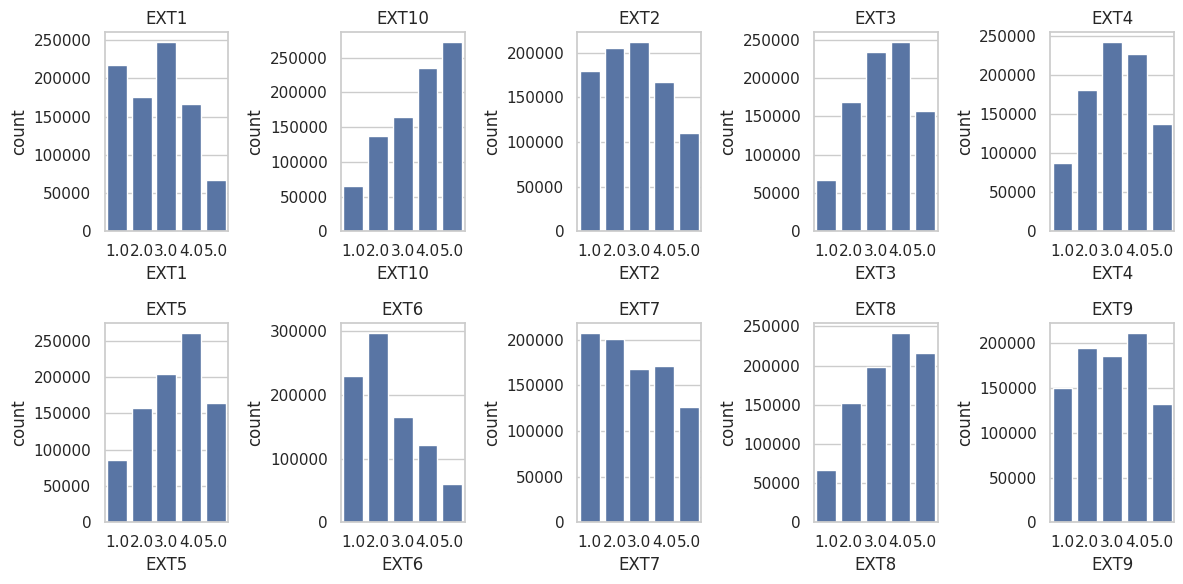

In [19]:
# distribucion de respuestas

plt.figure(figsize=(12, 6))
for i, col in enumerate(item_cols[:10]):  # 10 items de ejemplo
    plt.subplot(2, 5, i+1)
    sns.countplot(x=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()


# ***Calculo de promedios por rasgo y etiqueta dominante***

Cada uno de los cinco rasgos se calcula como el promedio de sus 10 items correspondientes, luego para cada persona:

- se comparan los cinco promedios (`EXT_MEAN`, `EST_MEAN`, `AGR_MEAN`, `CSN_MEAN`, `OPN_MEAN`)
- se elige el rasgo con valor mas alto como "rasgo dominante"
- ese rasgo dominante sera la etiqueta (clase) que intentara predecir nuestro MLP

Esto convierte el problema en una clasificación multiclase con 5 clases (una por cada rasgo).


In [20]:
# calculo de puntajes promedio por rasgo y definicion de clase objetivo

# calculamos el promedio por rasgo (promedio de sus items)
for pref in trait_prefixes:
    cols = trait_items[pref]
    df[pref + "_MEAN"] = df[cols].mean(axis=1)

mean_cols = [p + "_MEAN" for p in trait_prefixes]
df[mean_cols].head()


,EXT_MEAN,EST_MEAN,AGR_MEAN,CSN_MEAN,OPN_MEAN
0,3.0,2.4,3.1,3.2,3.3
1,3.4,2.1,3.2,3.1,2.7
2,2.9,2.6,2.8,2.8,3.1
3,2.6,2.7,3.2,2.7,3.1
4,3.5,2.3,3.0,3.2,3.6


In [21]:
# distribucion de los puntajes promedio por rasgo
df[mean_cols].describe()


,EXT_MEAN,EST_MEAN,AGR_MEAN,CSN_MEAN,OPN_MEAN
count,874434.000000,874434.000000,874434.000000,874434.000000,874434.000000
mean,3.040937,3.043880,3.176098,3.146615,3.292384
std,0.337695,0.647648,0.349868,0.380079,0.374339
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.800000,2.600000,3.000000,2.900000,3.100000
50%,3.000000,3.000000,3.200000,3.100000,3.300000
75%,3.200000,3.500000,3.400000,3.400000,3.600000
max,5.000000,5.000000,5.000000,5.000000,5.000000


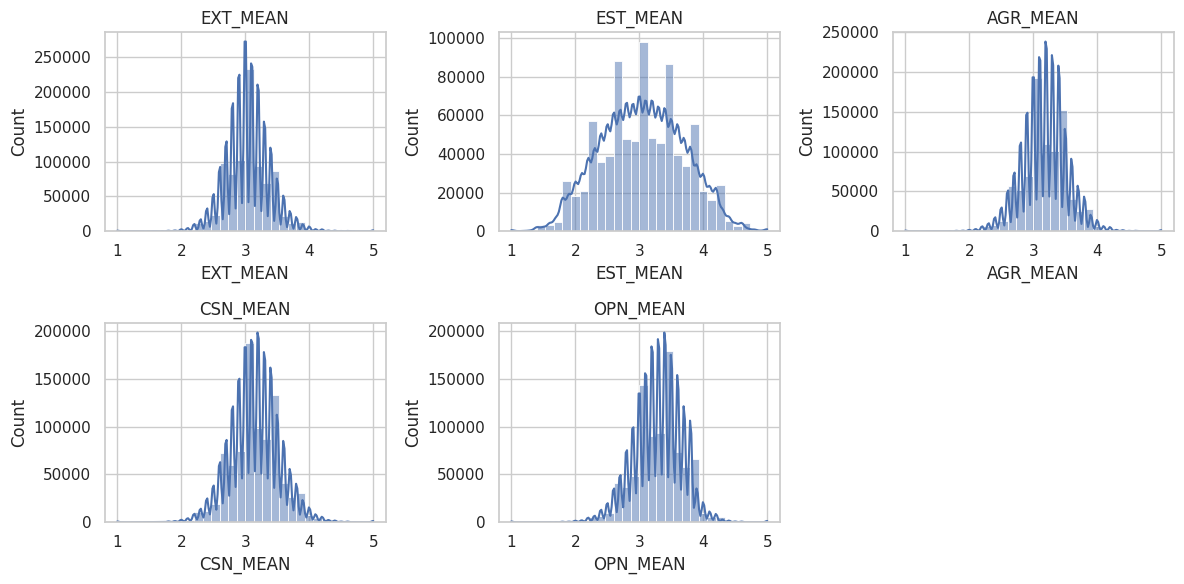

In [22]:
# distribuciones de los puntajes promedio

plt.figure(figsize=(12, 6))
for i, col in enumerate(mean_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


In [23]:
# definicion de la clase objetivo como el rasgo dominante (el de mayor puntaje medio)

# np.argmax sobre las columnas [EXT_MEAN, EST_MEAN, AGR_MEAN, CSN_MEAN, OPN_MEAN]
trait_idx = np.argmax(df[mean_cols].values, axis=1)  # valores 0..4

# Mapa index que es el nombre del rasgo
trait_name_map = {
    0: "EXT",  # Extroversion
    1: "EST",  # Neuroticismo / Estabilidad emocional
    2: "AGR",  # Amabilidad
    3: "CSN",  # Responsabilidad / Escrupulosidad
    4: "OPN"   # Apertura a la experiencia
}

df["dominant_trait_idx"] = trait_idx
df["dominant_trait"] = df["dominant_trait_idx"].map(trait_name_map)

df[["dominant_trait_idx", "dominant_trait"] + mean_cols].head()


,dominant_trait_idx,dominant_trait,EXT_MEAN,EST_MEAN,AGR_MEAN,CSN_MEAN,OPN_MEAN
0,4,OPN,3.0,2.4,3.1,3.2,3.3
1,0,EXT,3.4,2.1,3.2,3.1,2.7
2,4,OPN,2.9,2.6,2.8,2.8,3.1
3,2,AGR,2.6,2.7,3.2,2.7,3.1
4,4,OPN,3.5,2.3,3.0,3.2,3.6


dominant_trait
OPN    252635
EST    236504
AGR    147729
CSN    124585
EXT    112981
Name: count, dtype: int64


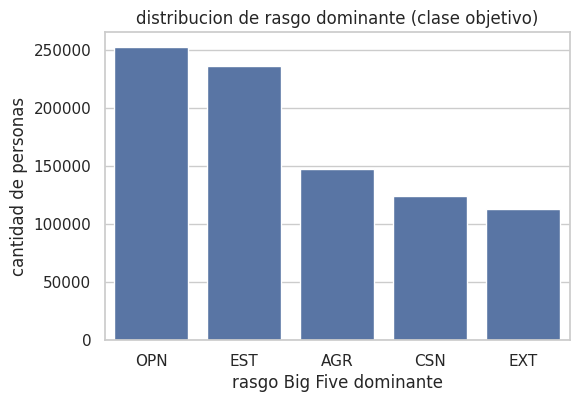

In [24]:
# distribucion de la clase (rasgo dominante)

class_counts = df["dominant_trait"].value_counts()
print(class_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("distribucion de rasgo dominante (clase objetivo)")
plt.xlabel("rasgo Big Five dominante")
plt.ylabel("cantidad de personas")
plt.show()


# construccion de features, division Train/Val/Test y escalado

se utiliza como entrada:

- los 50 items originales de la prueba Big Five valores de 1 a 5.

Como salida:

- la clase `dominant_trait_idx` que indica cual de los cinco rasgos es dominante

Pasos:

1. definir `X` con los items
2. definir `y` con el indice de rasgo dominante
3. dividir el dataset en train (70%), validacion (15%) y test (15%)
4. estandarizar las features usando `StandardScaler` (media 0, varianza 1)


In [26]:
# definicion de features (X) y target (y)

# en este caso se usa directamente las respuestas a los 50 items como features
X = df[item_cols].astype(float).values  # (n_samples, 50)
y = df["dominant_trait_idx"].astype(int).values  # (n_samples,)

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Clases (idx, counts):", np.unique(y, return_counts=True))


Shape X: (874434, 50)
Shape y: (874434,)
Clases (idx, counts): (array([0, 1, 2, 3, 4]), array([112981, 236504, 147729, 124585, 252635]))


In [27]:
# division Train / Val / Test

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=seed,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=seed,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (612103, 50)
Val:   (131165, 50)
Test:  (131166, 50)


# ***creacion de datasets y dataLoaders con PyTorch***

Para entrenar el MLP en PyTorch se hace lo siguiente:

- Un `Dataset` personalizado que devuelve `(features, label)` por muestra
- `DataLoader` para cargar los datos en batches durante el entrenamiento

Esto hace que podamos tener:
- Los datos con `shuffle=True`
- Manejo de los tensores en GPU.


In [28]:
# escalar features StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# conversion a tensores
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train,       dtype=torch.long)

X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val,         dtype=torch.long)

X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,        dtype=torch.long)


In [29]:
# dataLoader para entrenamiento, validacion y test

batch_size = 256

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t,   y_val_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


(2392, 513, 513)

# ***Definicion del modelo MLP (Red Feedforward)***

Se implementa un Multi-Layer Perceptron (MLP) con las siguientes caracteristicas:

- Entrada de 50 items del Big Five (escalados).
- Arquitectura:
  - Capa  de 256 neuronas + BatchNorm + ReLU + Dropout
  - Capa  de 128 neuronas + BatchNorm + ReLU + Dropout
  - Capa  de 64 neuronas + BatchNorm + ReLU + Dropout
- Capa de salida de 5 neuronas (una por cada rasgo dominante).

Se utiliza:
- Funcion de activacion `ReLU`
- Perdida `CrossEntropyLoss`
- Optimizador `Adam`
- Scheduler `ReduceLROnPlateau` para reducir el learning rate si la validacion deja de mejorar


In [30]:
# definicion del MLP para clasificacion de rasgo dominante Big Five

input_dim = X_train_t.shape[1]   # numero de features de 50 items
num_classes = len(trait_name_map)  # 5 rasgos

class BigFiveMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(BigFiveMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = BigFiveMLP(input_dim=input_dim, num_classes=num_classes).to(device)
print(model)


BigFiveMLP(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=5, bias=True)
  )
)


# ***Entrenamiento del MLP***

En esta seccion se entrena el modelo durante varias epoch:

- Para cada epoch:
  - se calcula el loss y accuracy en entrenamiento
  - se evalua en el conjunto de validacion
  - se registra el historial de `train_loss`, `val_loss`, `train_acc` y `val_acc`
  - si la perdida de validacion mejora se guarda un checkpoint del mejor modelo
  - el `scheduler` reduce el `learning rate` automaticamente cuando la perdida de validacion se estanca



In [31]:
# funcion de perdida, optimizador y scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

num_epochs = 50

train_losses = []
val_losses   = []
train_accuracies = []
val_accuracies   = []

best_val_loss = float("inf")
best_model_path = "best_bigfive_mlp.pth"


In [32]:
# loop de entrenamiento con validacion

for epoch in range(num_epochs):
    # ---- Entrenamiento ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = outputs.max(1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc  = correct / total

    # ---- Validacion ----
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_val_loss += loss.item() * X_batch.size(0)
            _, preds = outputs.max(1)
            total_val += y_batch.size(0)
            correct_val += (preds == y_batch).sum().item()

    epoch_val_loss = running_val_loss / total_val
    epoch_val_acc  = correct_val / total_val

    scheduler.step(epoch_val_loss)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    # guardar mejor modelo segun val_loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


Epoch [1/50] Train Loss: 0.2256 Acc: 0.9080 | Val Loss: 0.0690 Acc: 0.9864
Epoch [2/50] Train Loss: 0.1359 Acc: 0.9444 | Val Loss: 0.0758 Acc: 0.9767
Epoch [3/50] Train Loss: 0.1238 Acc: 0.9489 | Val Loss: 0.0705 Acc: 0.9699
Epoch [4/50] Train Loss: 0.1167 Acc: 0.9521 | Val Loss: 0.0391 Acc: 0.9955
Epoch [5/50] Train Loss: 0.1107 Acc: 0.9546 | Val Loss: 0.0602 Acc: 0.9852
Epoch [6/50] Train Loss: 0.1090 Acc: 0.9556 | Val Loss: 0.0417 Acc: 0.9976
Epoch [7/50] Train Loss: 0.1059 Acc: 0.9570 | Val Loss: 0.0518 Acc: 0.9914
Epoch [8/50] Train Loss: 0.1030 Acc: 0.9582 | Val Loss: 0.0408 Acc: 0.9933
Epoch [9/50] Train Loss: 0.0926 Acc: 0.9629 | Val Loss: 0.0477 Acc: 0.9763
Epoch [10/50] Train Loss: 0.0915 Acc: 0.9633 | Val Loss: 0.0386 Acc: 0.9922
Epoch [11/50] Train Loss: 0.0890 Acc: 0.9643 | Val Loss: 0.0450 Acc: 0.9908
Epoch [12/50] Train Loss: 0.0865 Acc: 0.9658 | Val Loss: 0.0345 Acc: 0.9898
Epoch [13/50] Train Loss: 0.0855 Acc: 0.9657 | Val Loss: 0.0283 Acc: 0.9943
Epoch [14/50] Train L

# ***Curvas de entrenamiento (Loss y Accuracy)***

se grafican:

- la loss en entrenamiento y validacion
- la evolucion del accuracy en entrenamiento y validacion

estas curvas permiten identificar:
- si el modelo esta aprendiendo con un loss decreciente
- si hay overfitting (que si hay un poco, pero logro tener un buen acc)


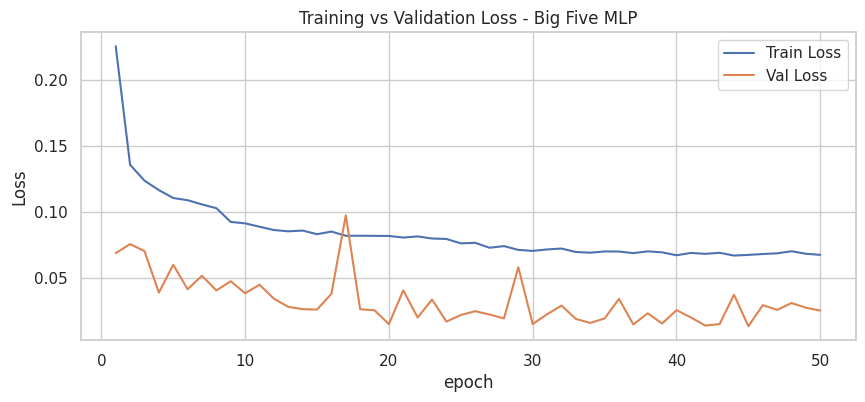

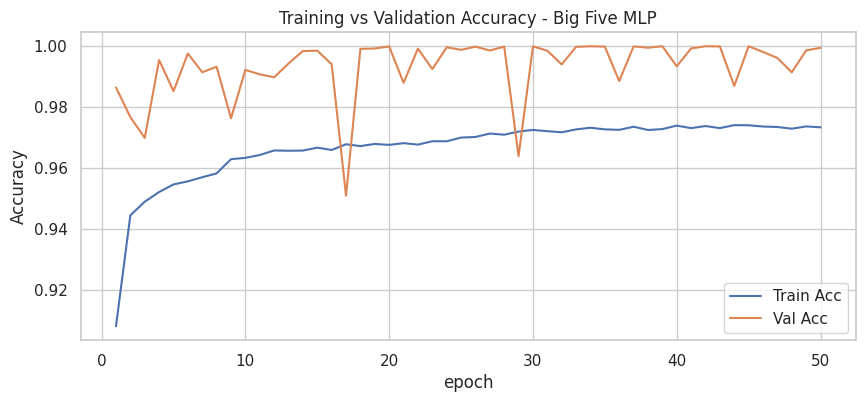

In [33]:
# curvas de Loss y Accuracy

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses,   label="Val Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Big Five MLP")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_accuracies, label="Train Acc")
plt.plot(epochs_range, val_accuracies,   label="Val Acc")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy - Big Five MLP")
plt.legend()
plt.grid(True)
plt.show()


# ***Evaluacion final en el conjunto de prueba***

esta seccion:

1. se carga el mejor checkpoint del modelo
2. se evalua en el conjunto test que no se haya visto durante el entrenamiento
3. se imprimen:
   - Metricas de `precision`, `recall`, `f1-score` por clase
   - Matriz de confusion para visualizar que rasgos se confunden entre si


In [34]:
# evaluacion final en el conjunto de prueba

# cargar el mejor modelo
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy en Test: {test_acc:.4f}")

print("\nReporte de clasificacion:\n")
target_names = [trait_name_map[i] for i in sorted(trait_name_map.keys())]
print(classification_report(all_labels, all_preds, target_names=target_names))


Accuracy en Test: 0.9999

Reporte de clasificacion:

              precision    recall  f1-score   support

         EXT       1.00      1.00      1.00     16947
         EST       1.00      1.00      1.00     35476
         AGR       1.00      1.00      1.00     22159
         CSN       1.00      1.00      1.00     18688
         OPN       1.00      1.00      1.00     37896

    accuracy                           1.00    131166
   macro avg       1.00      1.00      1.00    131166
weighted avg       1.00      1.00      1.00    131166



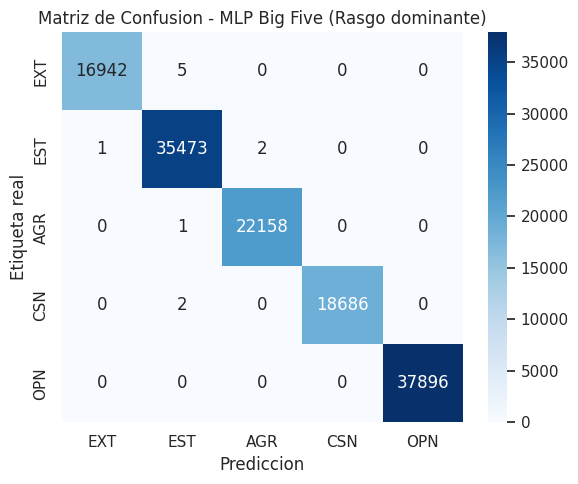

In [35]:
# matriz de confusion

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Prediccion")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusion - MLP Big Five (Rasgo dominante)")
plt.tight_layout()
plt.show()


# ***Ejemplos de predicciones y analisis de errores***

Finalmente se muestran algunos ejemplos del conjunto de prueba:

- para cada participante:
  - se muestra el rasgo verdadero (ground truth).
  - se muestra el rasgo predicho por el modelo.

esto permite hacer un analisis cualitativo de:
- casos correctamente clasificados.
- casos donde el modelo se equivoca (por ejemplo confunde apertura con amabilidad).


In [36]:
# ejemplos de predicciones correctas e incorrectas

def trait_idx_to_name(idx):
    return trait_name_map[int(idx)]

examples_to_show = 15

indices = np.arange(len(all_labels))
np.random.shuffle(indices)

print("Ejemplos de predicciones (algunas correctas y otras incorrectas):\n")
for i in indices[:examples_to_show]:
    true_label = trait_idx_to_name(all_labels[i])
    pred_label = trait_idx_to_name(all_preds[i])

    print(" Real: {true_label} | Predicho: {pred_label}")


Ejemplos de predicciones (algunas correctas y otras incorrectas):

 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}
 Real: {true_label} | Predicho: {pred_label}


# ***Conclusiones y posibles mejoras***

Para este caso se implemento un MLP (Multi-Layer Perceptron) para predecir el rasgo de personalidad dominante de Big Five a partir de las respuestas a 50 items de un test psicologico.

### Resultados principales

- el modelo alcanza una accuracy en test de aproximadamente 98%
- las metricas de `precision`, `recall` y `f1-score` muestran que:
  - algunos rasgos se predicen mejor que otros
  - existen confusiones entre rasgos conceptualmente cercanos

### Consideraciones

- se utiliza un dataset real y masivo.
- se implementa todo el flujo de Deep Learning:
  - de EDA a preprocesamiento a split a escalado a diseño de MLP a entrenamiento a evaluacion.
- en el MLP:
  - varias capas.
  - batch normalization y dropout para mejorar la generalizacion.
  - scheduler de learning rate.

### Limitaciones y mejoras futuras

- el rasgo dominante puede ser ambiguo cuando los promedios de rasgos estan muy cercanos.
- el modelo solo utiliza items del cuestionario; podria mejorar con:
  - Otras variables demograficas.
  - Tecnicas de representaciones aprendidas como embeddings.
- Se podria comparar el MLP con otras arquitecturas como:
  - Modelos lineales (baseline).
  - arboles de decision o Random Forest.
  - un modelo simple tipo transformer para las correlaciones entre items.

En este proyecto se muestra como un MLP feedforward puede aprender patrones en datos psicologicos de escala Likert para predecir rasgos de personalidad.
